In [ ]:
import os
from z3 import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def parse_dat_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
        m = int(lines[0].strip())
        n = int(lines[1].strip())
        l_values = list(map(int, lines[2].strip().split()))
        s_values = list(map(int, lines[3].strip().split()))
        distance_matrix = [list(map(int, line.strip().split())) for line in lines[4:]]
        
        return {
            'm': m,
            'n': n,
            'l_values': l_values,
            's_values': s_values,
            'distance_matrix': distance_matrix
        }

def read_dat_files(folder_path):
    dat_files = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    instances = {}
    
    for dat_file in dat_files:
        file_path = os.path.join(folder_path, dat_file)
        instances[dat_file] = parse_dat_file(file_path)
    
    return instances

folder_path = 'Instances'  # Adjust this path as necessary
instances = read_dat_files(folder_path)

# Display parsed data for verification
for filename, data in instances.items():
    print(f"Filename: {filename}")
    print(f"m: {data['m']}")
    print(f"n: {data['n']}")
    print(f"l_values: {data['l_values']}")
    print(f"s_values: {data['s_values']}")
    print(f"distance_matrix: {data['distance_matrix']}")
    print()

In [2]:
def solve_mcp(instance, timeout=300000):
    m = instance['m']
    n = instance['n']
    l_values = instance['l_values']
    s_values = instance['s_values']
    D = instance['distance_matrix']
    
    # Define the Z3 variables
    X = [[Bool(f'x_{i}_{j}') for j in range(n)] for i in range(m)]
    courier_distance = [Int(f'courier_distance_{i}') for i in range(m)]
    max_distance = Int('max_distance')
    
    s = Solver()
    s.set("timeout", timeout)  # Set the timeout in milliseconds (300000 ms = 300 seconds)
    
    # Constraints: Each item must be assigned to exactly one courier
    for j in range(n):
        s.add(Sum([If(X[i][j], 1, 0) for i in range(m)]) == 1)
    
    # Constraints: Each courier's load must not exceed its capacity
    for i in range(m):
        s.add(Sum([If(X[i][j], s_values[j], 0) for j in range(n)]) <= l_values[i])
    
    # Constraints: Define the travel times and ensure tours start and end at the origin
    for i in range(m):
        travel_distance = Sum([If(X[i][j], D[n][j] + D[j][n], 0) for j in range(n)])
        s.add(courier_distance[i] == travel_distance)
    
    # Constraint: Max distance is the maximum of all courier distances
    for i in range(m):
        s.add(max_distance >= courier_distance[i])
    
    # Binary search to minimize the maximum distance
    low, high = 0, sum(sum(row) for row in D)  # initial bounds for binary search
    optimal_solution = None

    while low <= high:
        mid = (low + high) // 2
        s.push()
        s.add(max_distance <= mid)
        if s.check() == sat:
            optimal_solution = (mid, s.model())
            high = mid - 1
        else:
            low = mid + 1
        s.pop()
    
    if optimal_solution:
        max_dist, model = optimal_solution
        solution = [[model.evaluate(X[i][j]) for j in range(n)] for i in range(m)]
        routes = []

        for i in range(m):
            route = [n]  # Start from the origin (index n)
            for j in range(n):
                if is_true(model.evaluate(X[i][j])):
                    route.append(j)
            route.append(n)  # Return to the origin
            routes.append(route)
        
        return max_dist, solution, routes
    else:
        return None

def generate_coordinates(n):
    # Create a circular layout for the distribution points
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    coordinates = {i: (radius * np.cos(angle), radius * np.sin(angle)) for i, angle in enumerate(theta)}
    coordinates[n] = (0, 0)  # Origin at the center
    return coordinates

def plot_routes(routes, instance):
    n = instance['n']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    coordinates = generate_coordinates(n)

    plt.figure(figsize=(8, 8))
    plt.grid(True)

    # Plot the nodes
    for i in range(n):
        plt.plot(*coordinates[i], 'o', color='white', markersize=10, markeredgecolor='black')
        plt.text(coordinates[i][0], coordinates[i][1], f'd{i+1}', fontsize=12, ha='right')

    # Plot the origin
    plt.plot(*coordinates[n], 'o', color='black', markersize=10)
    plt.text(coordinates[n][0], coordinates[n][1], 'origin', fontsize=12, ha='right')

    # Plot the routes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        for j in range(len(route) - 1):
            start = coordinates[route[j]]
            end = coordinates[route[j+1]]
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=0.05, length_includes_head=True)

    plt.xlabel('x')
    plt.ylabel('y')

    # Create custom legend
    legend_elements = [Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Courier {i+1}')
                       for i in range(len(routes))]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.show()

Instance: inst01.dat
Max Distance: 21
Courier 1: Items [3, 4, 6]
Courier 1 Route: [7, 3, 4, 6, 7]
Courier 2: Items [1, 2, 5]
Courier 2 Route: [7, 1, 2, 5, 7]


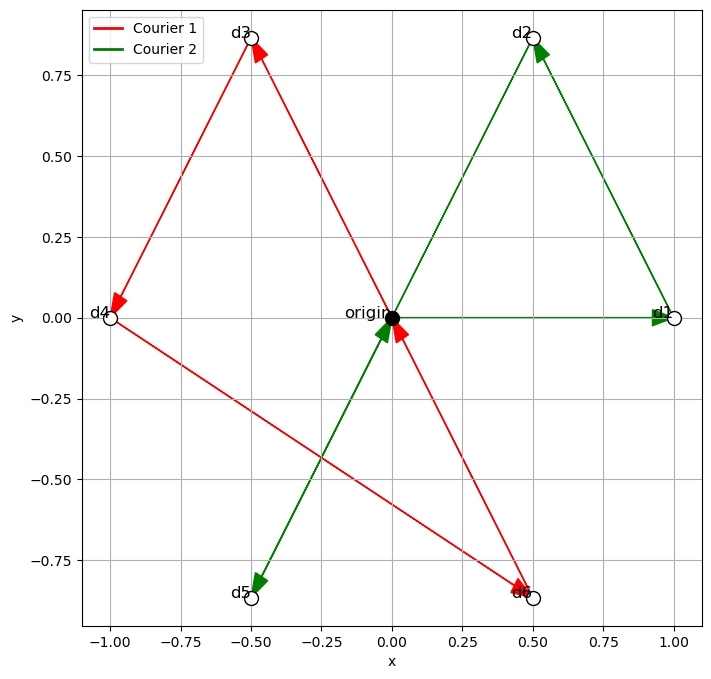

Instance: inst02.dat
Max Distance: 306
Courier 1: Items [5]
Courier 1 Route: [10, 5, 10]
Courier 2: Items [3, 6]
Courier 2 Route: [10, 3, 6, 10]
Courier 3: Items [1, 9]
Courier 3 Route: [10, 1, 9, 10]
Courier 4: Items [8]
Courier 4 Route: [10, 8, 10]
Courier 5: Items [2]
Courier 5 Route: [10, 2, 10]
Courier 6: Items [4, 7]
Courier 6 Route: [10, 4, 7, 10]


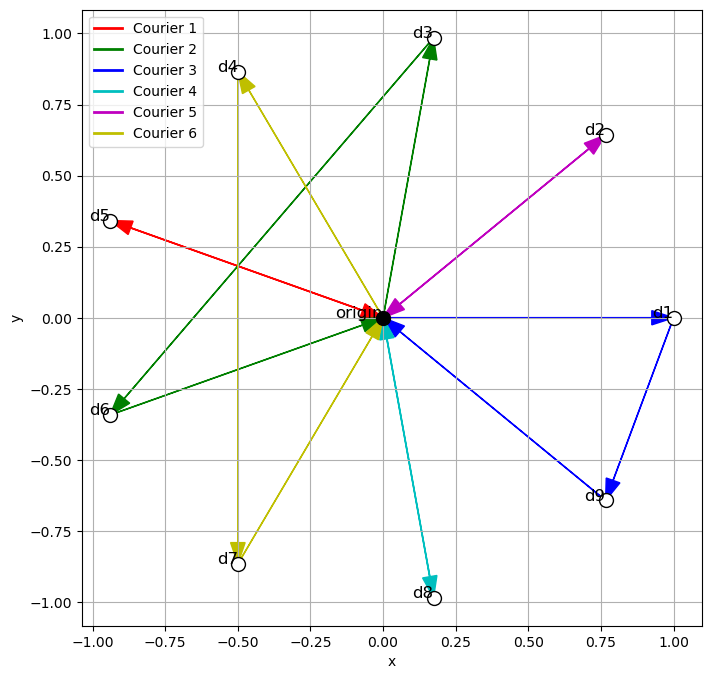

Instance: inst03.dat
Max Distance: 20
Courier 1: Items [3, 5, 6]
Courier 1 Route: [8, 3, 5, 6, 8]
Courier 2: Items [2, 4]
Courier 2 Route: [8, 2, 4, 8]
Courier 3: Items [1, 7]
Courier 3 Route: [8, 1, 7, 8]


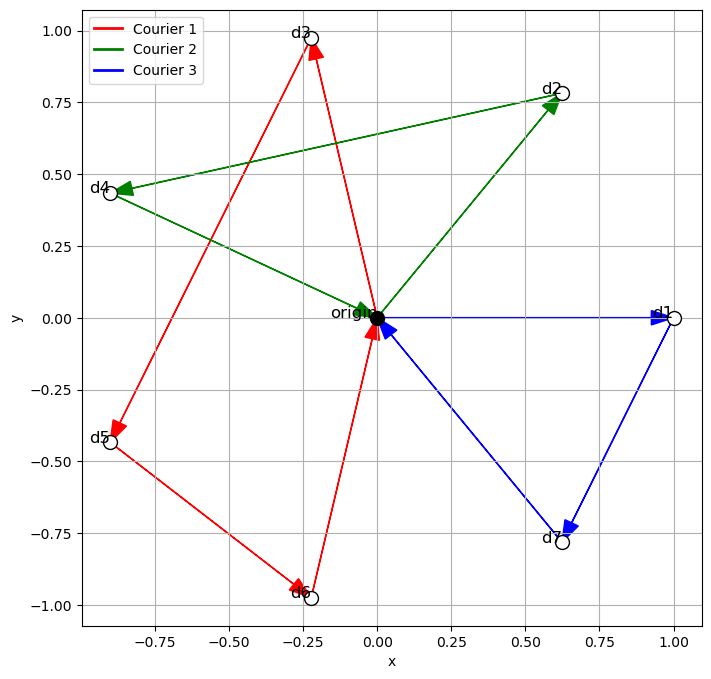

Instance: inst04.dat
Max Distance: 220
Courier 1: Items []
Courier 1 Route: [11, 11]
Courier 2: Items [1, 9]
Courier 2 Route: [11, 1, 9, 11]
Courier 3: Items [7, 10]
Courier 3 Route: [11, 7, 10, 11]
Courier 4: Items [4]
Courier 4 Route: [11, 4, 11]
Courier 5: Items [3, 5]
Courier 5 Route: [11, 3, 5, 11]
Courier 6: Items [6]
Courier 6 Route: [11, 6, 11]
Courier 7: Items [8]
Courier 7 Route: [11, 8, 11]
Courier 8: Items [2]
Courier 8 Route: [11, 2, 11]


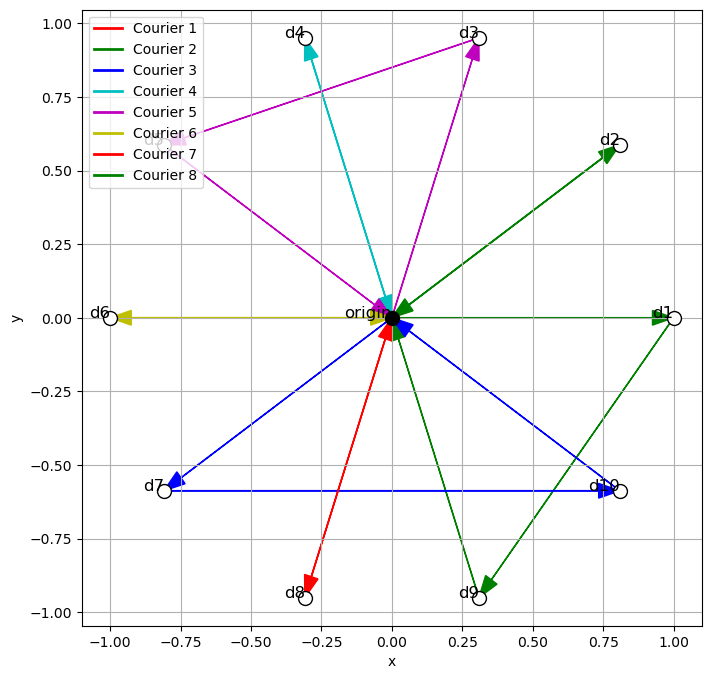

Instance: inst05.dat
Max Distance: 280
Courier 1: Items [2]
Courier 1 Route: [4, 2, 4]
Courier 2: Items [1, 3]
Courier 2 Route: [4, 1, 3, 4]


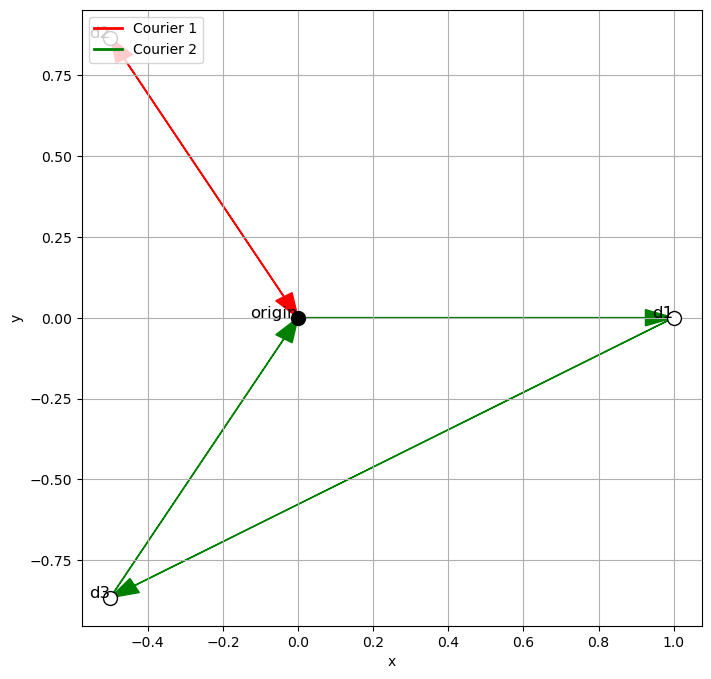

Instance: inst06.dat
Max Distance: 322
Courier 1: Items [5]
Courier 1 Route: [9, 5, 9]
Courier 2: Items [4]
Courier 2 Route: [9, 4, 9]
Courier 3: Items [8]
Courier 3 Route: [9, 8, 9]
Courier 4: Items [1, 7]
Courier 4 Route: [9, 1, 7, 9]
Courier 5: Items [3]
Courier 5 Route: [9, 3, 9]
Courier 6: Items [2, 6]
Courier 6 Route: [9, 2, 6, 9]


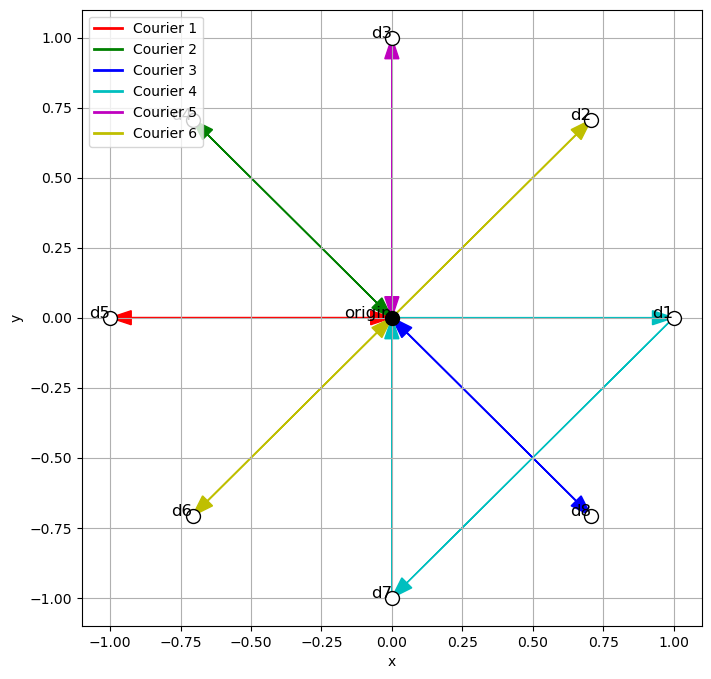

Instance: inst07.dat
Max Distance: 277
Courier 1: Items [2, 11, 15]
Courier 1 Route: [18, 2, 11, 15, 18]
Courier 2: Items [4, 5]
Courier 2 Route: [18, 4, 5, 18]
Courier 3: Items [6, 7, 13]
Courier 3 Route: [18, 6, 7, 13, 18]
Courier 4: Items [1, 9, 17]
Courier 4 Route: [18, 1, 9, 17, 18]
Courier 5: Items [3, 8, 10]
Courier 5 Route: [18, 3, 8, 10, 18]
Courier 6: Items [12, 14, 16]
Courier 6 Route: [18, 12, 14, 16, 18]


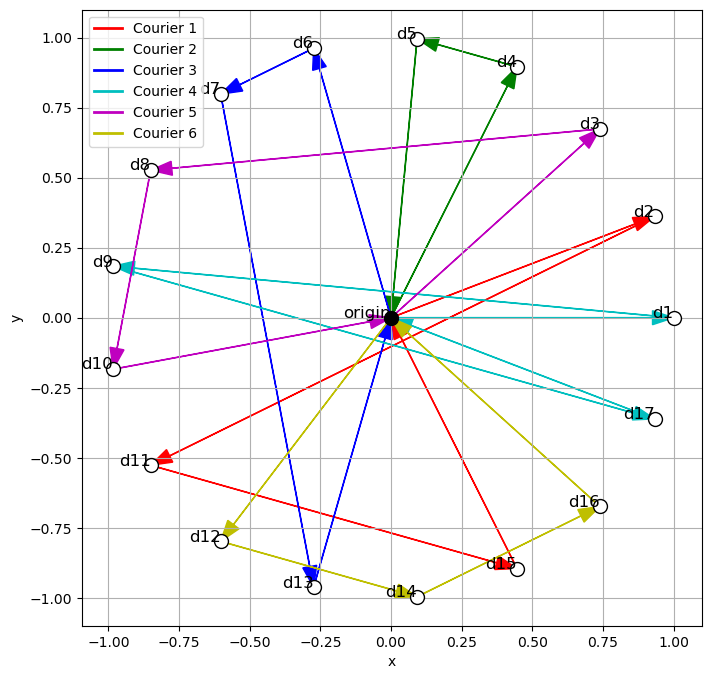

Instance: inst08.dat
Max Distance: 186
Courier 1: Items [6]
Courier 1 Route: [11, 6, 11]
Courier 2: Items [3]
Courier 2 Route: [11, 3, 11]
Courier 3: Items [2, 7]
Courier 3 Route: [11, 2, 7, 11]
Courier 4: Items [8]
Courier 4 Route: [11, 8, 11]
Courier 5: Items [10]
Courier 5 Route: [11, 10, 11]
Courier 6: Items [4, 5]
Courier 6 Route: [11, 4, 5, 11]
Courier 7: Items [1]
Courier 7 Route: [11, 1, 11]
Courier 8: Items [9]
Courier 8 Route: [11, 9, 11]


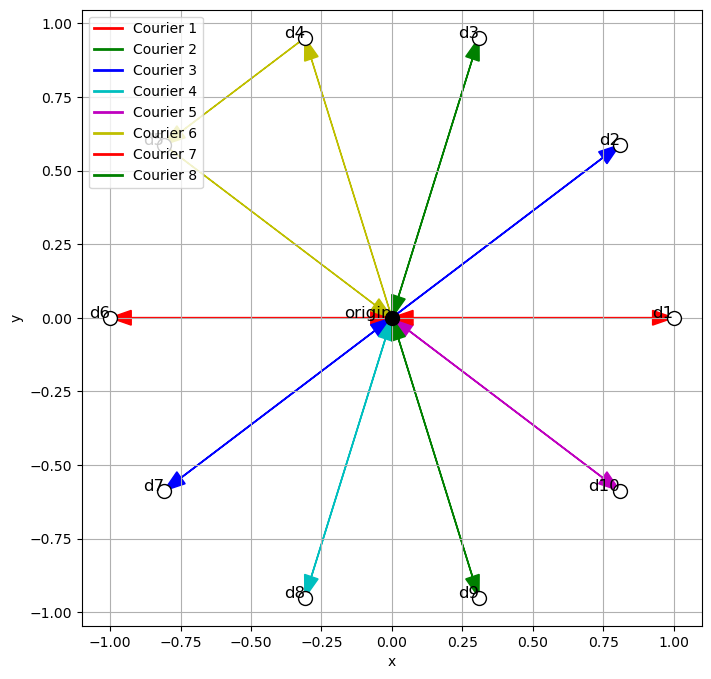

Instance: inst09.dat
Max Distance: 436
Courier 1: Items [6]
Courier 1 Route: [14, 6, 14]
Courier 2: Items [1, 11]
Courier 2 Route: [14, 1, 11, 14]
Courier 3: Items [13]
Courier 3 Route: [14, 13, 14]
Courier 4: Items [2, 7]
Courier 4 Route: [14, 2, 7, 14]
Courier 5: Items [3]
Courier 5 Route: [14, 3, 14]
Courier 6: Items [5, 12]
Courier 6 Route: [14, 5, 12, 14]
Courier 7: Items [9]
Courier 7 Route: [14, 9, 14]
Courier 8: Items [8]
Courier 8 Route: [14, 8, 14]
Courier 9: Items [4]
Courier 9 Route: [14, 4, 14]
Courier 10: Items [10]
Courier 10 Route: [14, 10, 14]


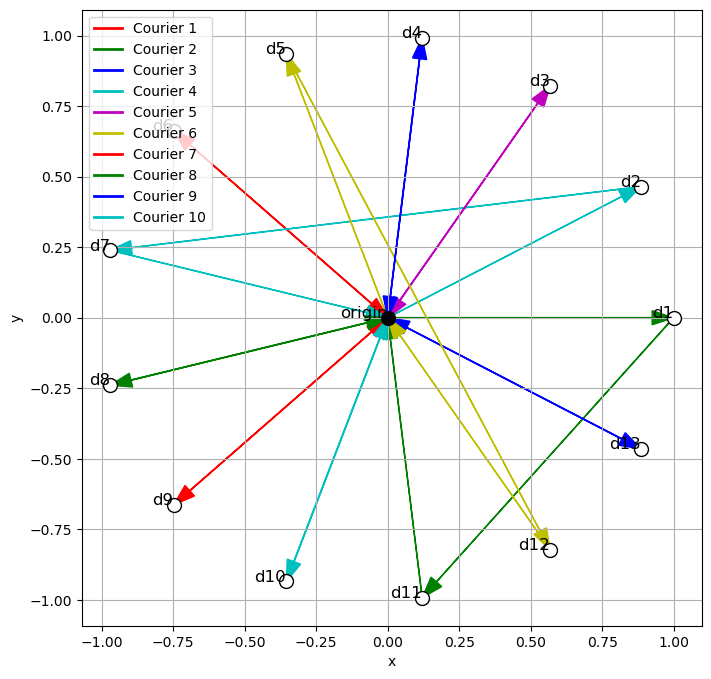

Instance: inst10.dat
Max Distance: 244
Courier 1: Items [5]
Courier 1 Route: [14, 5, 14]
Courier 2: Items [1, 11]
Courier 2 Route: [14, 1, 11, 14]
Courier 3: Items [9]
Courier 3 Route: [14, 9, 14]
Courier 4: Items [3, 7]
Courier 4 Route: [14, 3, 7, 14]
Courier 5: Items [13]
Courier 5 Route: [14, 13, 14]
Courier 6: Items [4]
Courier 6 Route: [14, 4, 14]
Courier 7: Items [2, 10]
Courier 7 Route: [14, 2, 10, 14]
Courier 8: Items [6]
Courier 8 Route: [14, 6, 14]
Courier 9: Items [8]
Courier 9 Route: [14, 8, 14]
Courier 10: Items [12]
Courier 10 Route: [14, 12, 14]


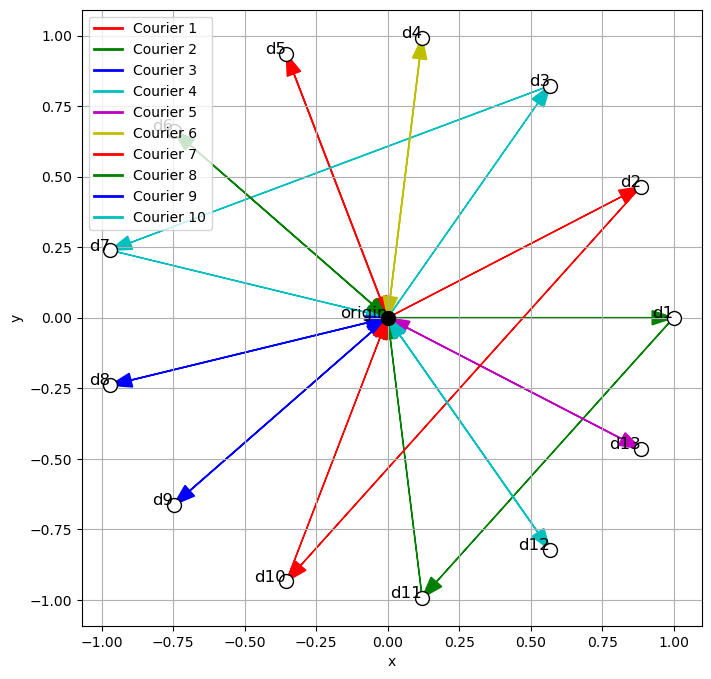

Instance: inst11.dat
Max Distance: 916
Courier 1: Items [2, 27, 36, 46, 48, 74, 137]
Courier 1 Route: [144, 2, 27, 36, 46, 48, 74, 137, 144]
Courier 2: Items [5, 11, 17, 54, 63, 112, 121, 129, 142]
Courier 2 Route: [144, 5, 11, 17, 54, 63, 112, 121, 129, 142, 144]
Courier 3: Items [13, 14, 16, 57, 60, 108, 130]
Courier 3 Route: [144, 13, 14, 16, 57, 60, 108, 130, 144]
Courier 4: Items [24, 29, 35, 89, 98, 120, 127]
Courier 4 Route: [144, 24, 29, 35, 89, 98, 120, 127, 144]
Courier 5: Items [4, 30, 51, 110, 133, 134]
Courier 5 Route: [144, 4, 30, 51, 110, 133, 134, 144]
Courier 6: Items [20, 32, 45, 59, 69, 84, 113, 131]
Courier 6 Route: [144, 20, 32, 45, 59, 69, 84, 113, 131, 144]
Courier 7: Items [9, 40, 49, 76, 106, 107]
Courier 7 Route: [144, 9, 40, 49, 76, 106, 107, 144]
Courier 8: Items [7, 42, 85, 86, 97, 128, 135]
Courier 8 Route: [144, 7, 42, 85, 86, 97, 128, 135, 144]
Courier 9: Items [28, 33, 43, 53, 80, 83, 125, 126]
Courier 9 Route: [144, 28, 33, 43, 53, 80, 83, 125, 126, 14

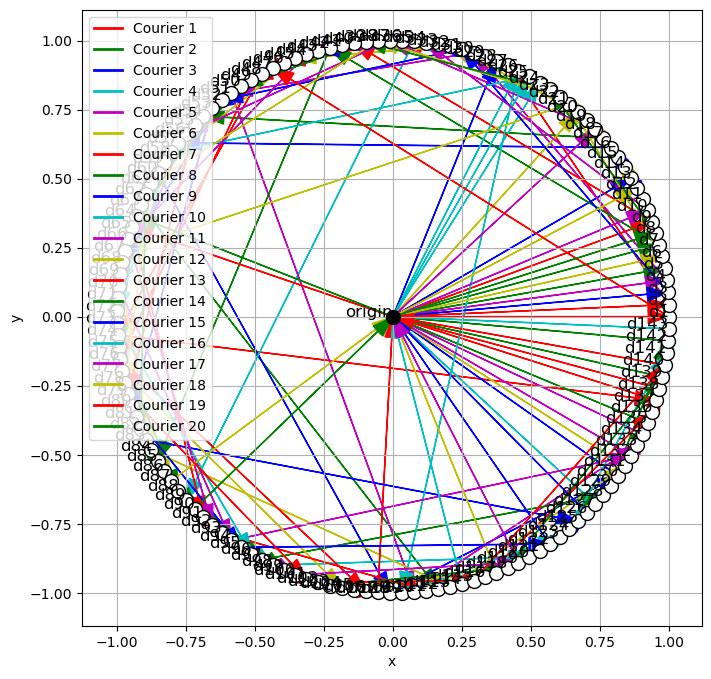

Instance: inst12.dat
Max Distance: 510
Courier 1: Items [8, 26, 59]
Courier 1 Route: [96, 8, 26, 59, 96]
Courier 2: Items [4, 20, 22, 72, 75]
Courier 2 Route: [96, 4, 20, 22, 72, 75, 96]
Courier 3: Items [12, 18, 41, 86, 88]
Courier 3 Route: [96, 12, 18, 41, 86, 88, 96]
Courier 4: Items [14, 37, 42, 63, 67]
Courier 4 Route: [96, 14, 37, 42, 63, 67, 96]
Courier 5: Items [28, 40, 49, 94]
Courier 5 Route: [96, 28, 40, 49, 94, 96]
Courier 6: Items [23, 34, 45, 71]
Courier 6 Route: [96, 23, 34, 45, 71, 96]
Courier 7: Items [5, 39, 65]
Courier 7 Route: [96, 5, 39, 65, 96]
Courier 8: Items [10, 27, 48, 57]
Courier 8 Route: [96, 10, 27, 48, 57, 96]
Courier 9: Items [1, 13, 16, 32, 84]
Courier 9 Route: [96, 1, 13, 16, 32, 84, 96]
Courier 10: Items [7, 61, 68]
Courier 10 Route: [96, 7, 61, 68, 96]
Courier 11: Items [3, 31, 54, 56, 62, 95]
Courier 11 Route: [96, 3, 31, 54, 56, 62, 95, 96]
Courier 12: Items [30, 38, 58, 83, 85]
Courier 12 Route: [96, 30, 38, 58, 83, 85, 96]
Courier 13: Items [24, 

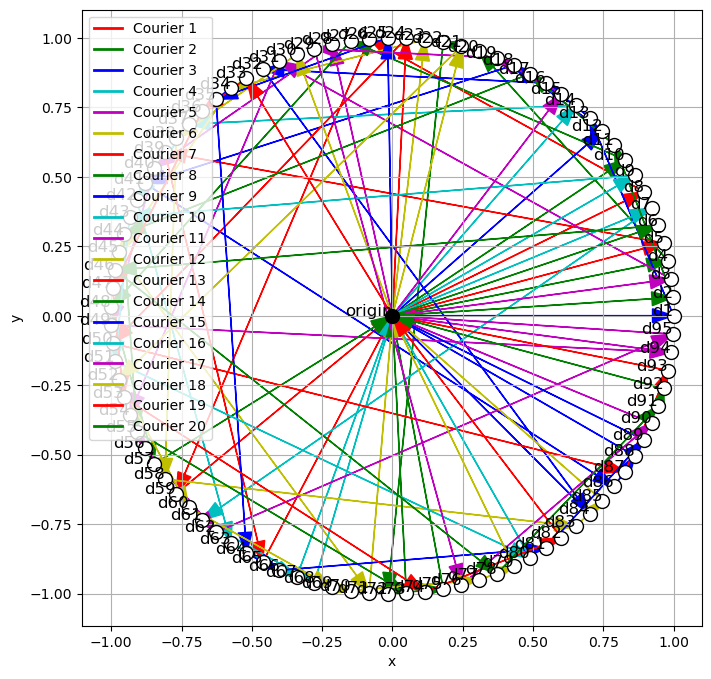

Instance: inst13.dat
Max Distance: 1886
Courier 1: Items [2, 4, 5, 10, 11, 12, 13, 14, 22, 23, 25, 28, 31, 32, 34, 36, 37, 43, 44, 45]
Courier 1 Route: [48, 2, 4, 5, 10, 11, 12, 13, 14, 22, 23, 25, 28, 31, 32, 34, 36, 37, 43, 44, 45, 48]
Courier 2: Items [6, 7, 8, 9, 15, 16, 17, 18, 19, 24, 38, 39, 42, 47]
Courier 2 Route: [48, 6, 7, 8, 9, 15, 16, 17, 18, 19, 24, 38, 39, 42, 47, 48]
Courier 3: Items [1, 3, 20, 21, 26, 27, 29, 30, 33, 35, 40, 41, 46]
Courier 3 Route: [48, 1, 3, 20, 21, 26, 27, 29, 30, 33, 35, 40, 41, 46, 48]


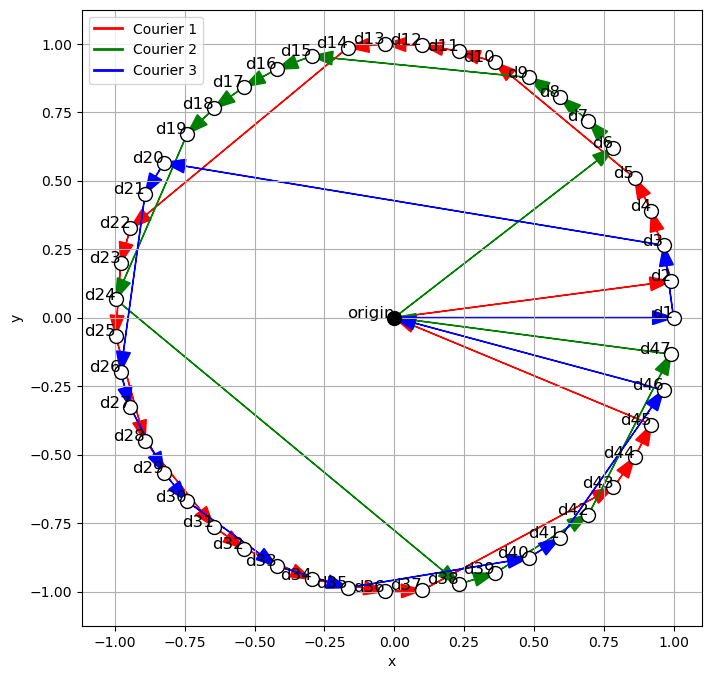

Instance: inst14.dat
Max Distance: 1410
Courier 1: Items [32, 63, 75, 97, 109, 128, 168, 191, 212]
Courier 1 Route: [216, 32, 63, 75, 97, 109, 128, 168, 191, 212, 216]
Courier 2: Items [3, 24, 28, 29, 52, 56, 64, 93, 138, 139, 142, 145, 174]
Courier 2 Route: [216, 3, 24, 28, 29, 52, 56, 64, 93, 138, 139, 142, 145, 174, 216]
Courier 3: Items [15, 18, 88, 94, 108, 134, 144, 186, 200]
Courier 3 Route: [216, 15, 18, 88, 94, 108, 134, 144, 186, 200, 216]
Courier 4: Items [8, 10, 26, 31, 36, 39, 73, 74, 103]
Courier 4 Route: [216, 8, 10, 26, 31, 36, 39, 73, 74, 103, 216]
Courier 5: Items [9, 71, 82, 91, 110, 116, 189, 198, 199, 205]
Courier 5 Route: [216, 9, 71, 82, 91, 110, 116, 189, 198, 199, 205, 216]
Courier 6: Items [25, 62, 92, 102, 121, 126, 131, 157, 182, 197, 211]
Courier 6 Route: [216, 25, 62, 92, 102, 121, 126, 131, 157, 182, 197, 211, 216]
Courier 7: Items [38, 41, 58, 65, 78, 120, 132, 135, 179, 193, 194, 203]
Courier 7 Route: [216, 38, 41, 58, 65, 78, 120, 132, 135, 179, 193, 1

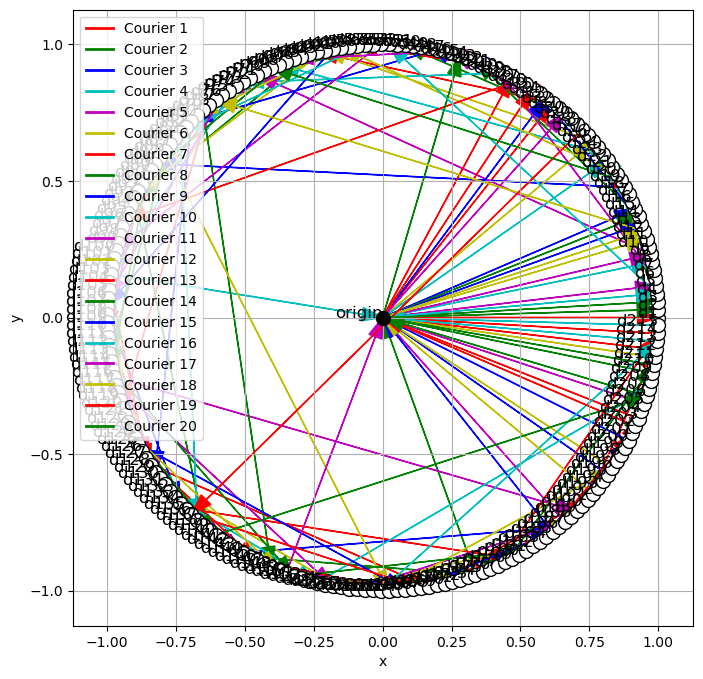

Instance: inst15.dat
Max Distance: 1202
Courier 1: Items [4, 22, 56, 72, 73, 100, 120, 141, 144, 162, 168, 200, 215]
Courier 1 Route: [240, 4, 22, 56, 72, 73, 100, 120, 141, 144, 162, 168, 200, 215, 240]
Courier 2: Items [3, 9, 11, 54, 70, 71, 80, 96, 125, 158, 161, 197, 199, 202]
Courier 2 Route: [240, 3, 9, 11, 54, 70, 71, 80, 96, 125, 158, 161, 197, 199, 202, 240]
Courier 3: Items [19, 52, 61, 64, 102, 126, 134, 175, 191, 198, 227]
Courier 3 Route: [240, 19, 52, 61, 64, 102, 126, 134, 175, 191, 198, 227, 240]
Courier 4: Items [29, 42, 62, 85, 89, 94, 112, 153, 172, 229, 234]
Courier 4 Route: [240, 29, 42, 62, 85, 89, 94, 112, 153, 172, 229, 234, 240]
Courier 5: Items [16, 31, 46, 48, 95, 124, 137, 171, 194]
Courier 5 Route: [240, 16, 31, 46, 48, 95, 124, 137, 171, 194, 240]
Courier 6: Items [12, 24, 78, 83, 110, 113, 114, 155, 182, 220]
Courier 6 Route: [240, 12, 24, 78, 83, 110, 113, 114, 155, 182, 220, 240]
Courier 7: Items [25, 81, 86, 97, 99, 118, 121, 139, 150, 157, 166, 188, 2

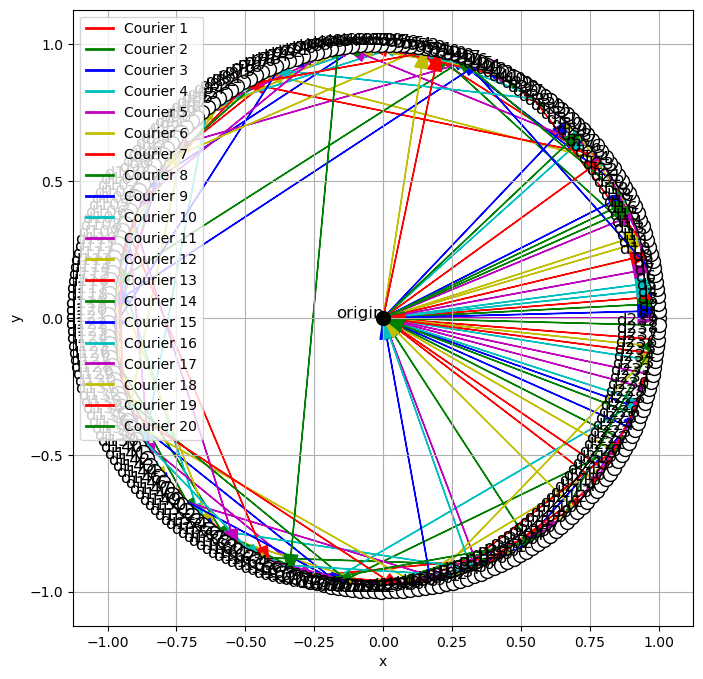

Instance: inst16.dat
Max Distance: 286
Courier 1: Items [2, 8]
Courier 1 Route: [48, 2, 8, 48]
Courier 2: Items [18, 35, 43]
Courier 2 Route: [48, 18, 35, 43, 48]
Courier 3: Items [6, 7, 30]
Courier 3 Route: [48, 6, 7, 30, 48]
Courier 4: Items [21, 28, 44]
Courier 4 Route: [48, 21, 28, 44, 48]
Courier 5: Items [17, 31, 39]
Courier 5 Route: [48, 17, 31, 39, 48]
Courier 6: Items [12, 47]
Courier 6 Route: [48, 12, 47, 48]
Courier 7: Items [9, 33]
Courier 7 Route: [48, 9, 33, 48]
Courier 8: Items [19, 23]
Courier 8 Route: [48, 19, 23, 48]
Courier 9: Items [1, 3]
Courier 9 Route: [48, 1, 3, 48]
Courier 10: Items [11, 14, 45]
Courier 10 Route: [48, 11, 14, 45, 48]
Courier 11: Items [16, 38]
Courier 11 Route: [48, 16, 38, 48]
Courier 12: Items [24, 27]
Courier 12 Route: [48, 24, 27, 48]
Courier 13: Items [5, 34]
Courier 13 Route: [48, 5, 34, 48]
Courier 14: Items [15, 26]
Courier 14 Route: [48, 15, 26, 48]
Courier 15: Items [29, 36, 37]
Courier 15 Route: [48, 29, 36, 37, 48]
Courier 16: Items

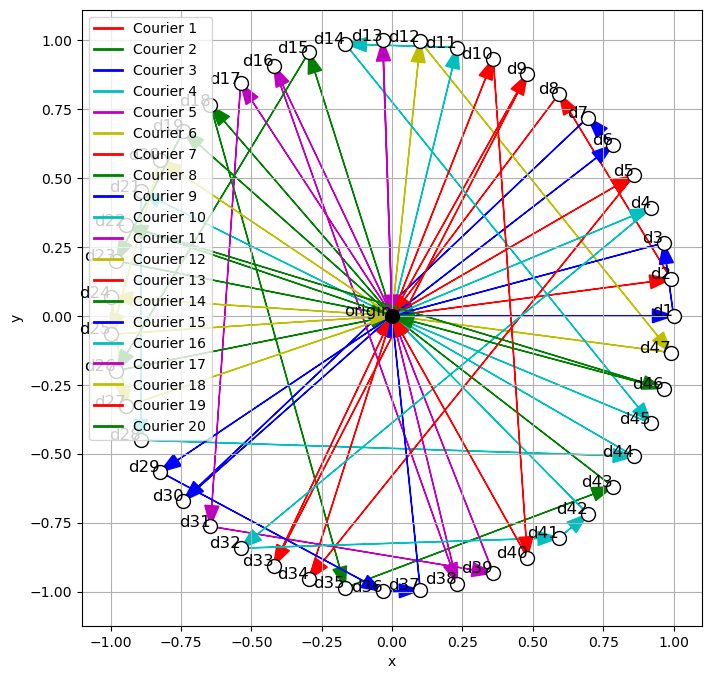

Instance: inst17.dat
Max Distance: 1947
Courier 1: Items [37, 61, 71, 96, 134, 212, 214, 226, 231, 235, 239, 244, 249, 270, 277, 284, 286]
Courier 1 Route: [288, 37, 61, 71, 96, 134, 212, 214, 226, 231, 235, 239, 244, 249, 270, 277, 284, 286, 288]
Courier 2: Items [1, 16, 64, 77, 79, 123, 130, 143, 147, 151, 173, 246, 256, 275]
Courier 2 Route: [288, 1, 16, 64, 77, 79, 123, 130, 143, 147, 151, 173, 246, 256, 275, 288]
Courier 3: Items [10, 34, 45, 74, 95, 102, 109, 112, 115, 128, 200, 255]
Courier 3 Route: [288, 10, 34, 45, 74, 95, 102, 109, 112, 115, 128, 200, 255, 288]
Courier 4: Items [20, 56, 70, 75, 107, 133, 150, 153, 157, 158, 179, 180, 223, 251, 258, 265]
Courier 4 Route: [288, 20, 56, 70, 75, 107, 133, 150, 153, 157, 158, 179, 180, 223, 251, 258, 265, 288]
Courier 5: Items [2, 3, 27, 63, 89, 144, 160, 183, 225, 243, 250, 269]
Courier 5 Route: [288, 2, 3, 27, 63, 89, 144, 160, 183, 225, 243, 250, 269, 288]
Courier 6: Items [9, 11, 12, 18, 32, 40, 43, 76, 81, 136, 148, 164, 189,

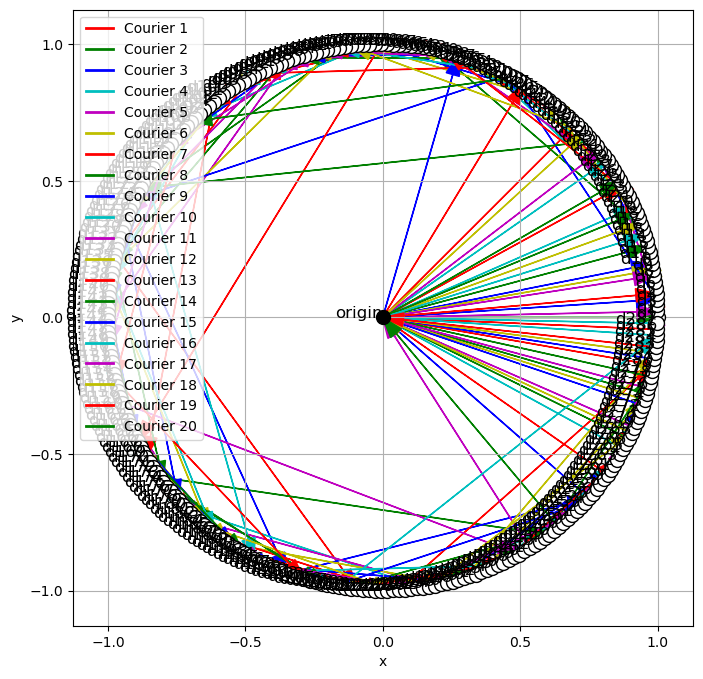

Instance: inst18.dat
Max Distance: 1150
Courier 1: Items [41, 103, 109, 116, 133, 149, 162, 173, 176, 186]
Courier 1 Route: [192, 41, 103, 109, 116, 133, 149, 162, 173, 176, 186, 192]
Courier 2: Items [2, 10, 12, 14, 49, 64, 65, 97, 121, 168, 179]
Courier 2 Route: [192, 2, 10, 12, 14, 49, 64, 65, 97, 121, 168, 179, 192]
Courier 3: Items [28, 30, 52, 75, 84, 120, 163, 174]
Courier 3 Route: [192, 28, 30, 52, 75, 84, 120, 163, 174, 192]
Courier 4: Items [80, 81, 92, 95, 108, 112, 128, 139, 161, 169]
Courier 4 Route: [192, 80, 81, 92, 95, 108, 112, 128, 139, 161, 169, 192]
Courier 5: Items [9, 33, 67, 106, 122, 136, 158, 170, 183]
Courier 5 Route: [192, 9, 33, 67, 106, 122, 136, 158, 170, 183, 192]
Courier 6: Items [18, 47, 76, 87, 100, 119, 146, 153, 177]
Courier 6 Route: [192, 18, 47, 76, 87, 100, 119, 146, 153, 177, 192]
Courier 7: Items [8, 19, 31, 60, 69, 77, 98, 132, 184, 191]
Courier 7 Route: [192, 8, 19, 31, 60, 69, 77, 98, 132, 184, 191, 192]
Courier 8: Items [7, 39, 53, 61, 72, 1

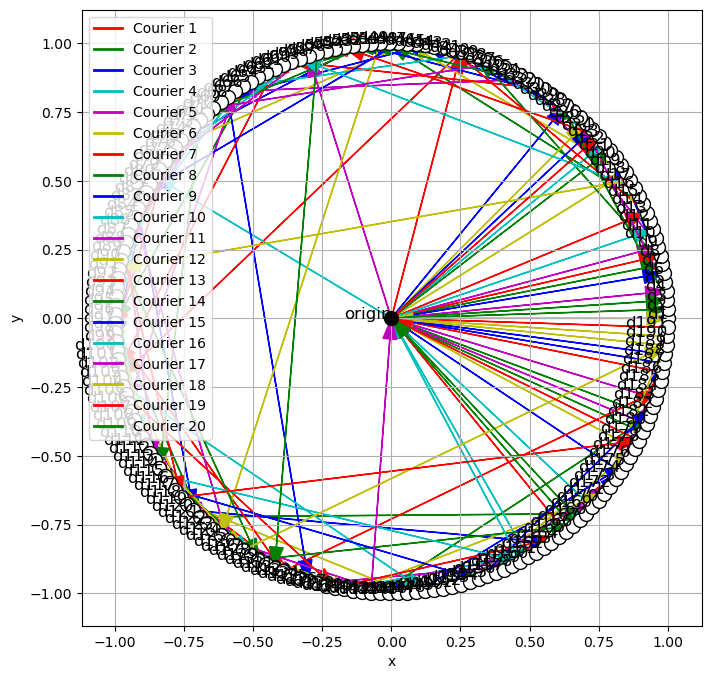

Instance: inst19.dat
Max Distance: 456
Courier 1: Items [8, 63, 71]
Courier 1 Route: [72, 8, 63, 71, 72]
Courier 2: Items [22, 27, 44, 45]
Courier 2 Route: [72, 22, 27, 44, 45, 72]
Courier 3: Items [32, 35, 41, 69]
Courier 3 Route: [72, 32, 35, 41, 69, 72]
Courier 4: Items [4, 21, 25, 42, 52, 60, 70]
Courier 4 Route: [72, 4, 21, 25, 42, 52, 60, 70, 72]
Courier 5: Items [43, 51, 68]
Courier 5 Route: [72, 43, 51, 68, 72]
Courier 6: Items [6, 36, 48, 61, 62]
Courier 6 Route: [72, 6, 36, 48, 61, 62, 72]
Courier 7: Items [18, 57]
Courier 7 Route: [72, 18, 57, 72]
Courier 8: Items [11, 28, 40, 50]
Courier 8 Route: [72, 11, 28, 40, 50, 72]
Courier 9: Items [9, 23, 54, 67]
Courier 9 Route: [72, 9, 23, 54, 67, 72]
Courier 10: Items [2, 29, 33]
Courier 10 Route: [72, 2, 29, 33, 72]
Courier 11: Items [16, 38, 46]
Courier 11 Route: [72, 16, 38, 46, 72]
Courier 12: Items [12, 30, 56, 58]
Courier 12 Route: [72, 12, 30, 56, 58, 72]
Courier 13: Items [1, 49]
Courier 13 Route: [72, 1, 49, 72]
Courier 1

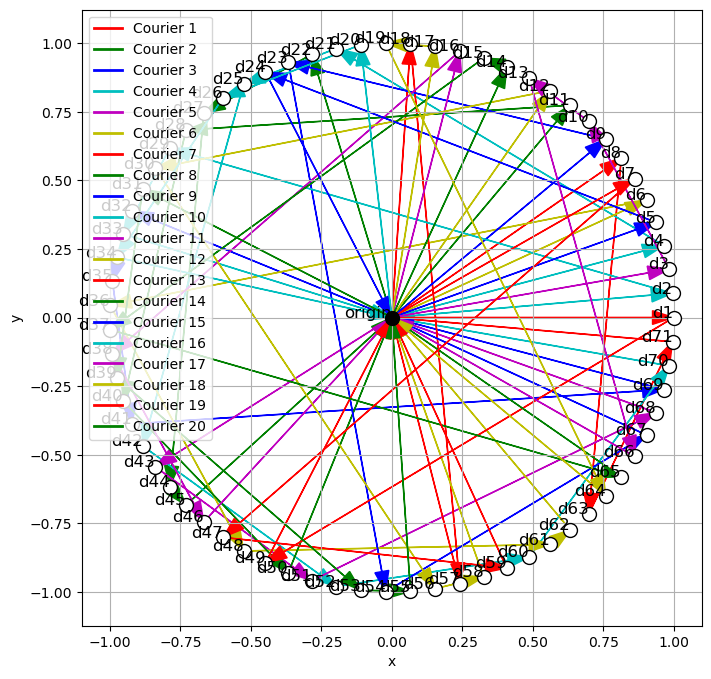

Instance: inst20.dat
Max Distance: 3034
Courier 1: Items [11, 36, 127, 138, 143, 149, 150, 151, 175, 221, 231, 262, 281]
Courier 1 Route: [288, 11, 36, 127, 138, 143, 149, 150, 151, 175, 221, 231, 262, 281, 288]
Courier 2: Items [9, 79, 91, 98, 119, 131, 136, 171, 174, 191, 193, 208, 211, 217, 219, 261]
Courier 2 Route: [288, 9, 79, 91, 98, 119, 131, 136, 171, 174, 191, 193, 208, 211, 217, 219, 261, 288]
Courier 3: Items [13, 20, 45, 62, 64, 68, 75, 81, 84, 90, 137, 153, 161, 177, 180, 212, 244, 263, 275]
Courier 3 Route: [288, 13, 20, 45, 62, 64, 68, 75, 81, 84, 90, 137, 153, 161, 177, 180, 212, 244, 263, 275, 288]
Courier 4: Items [10, 54, 78, 130, 159, 165, 167, 190, 216, 218, 251, 256, 268, 273]
Courier 4 Route: [288, 10, 54, 78, 130, 159, 165, 167, 190, 216, 218, 251, 256, 268, 273, 288]
Courier 5: Items [14, 26, 85, 88, 148, 156, 162, 173, 185, 200, 209, 213, 247, 248, 279]
Courier 5 Route: [288, 14, 26, 85, 88, 148, 156, 162, 173, 185, 200, 209, 213, 247, 248, 279, 288]
Courier 

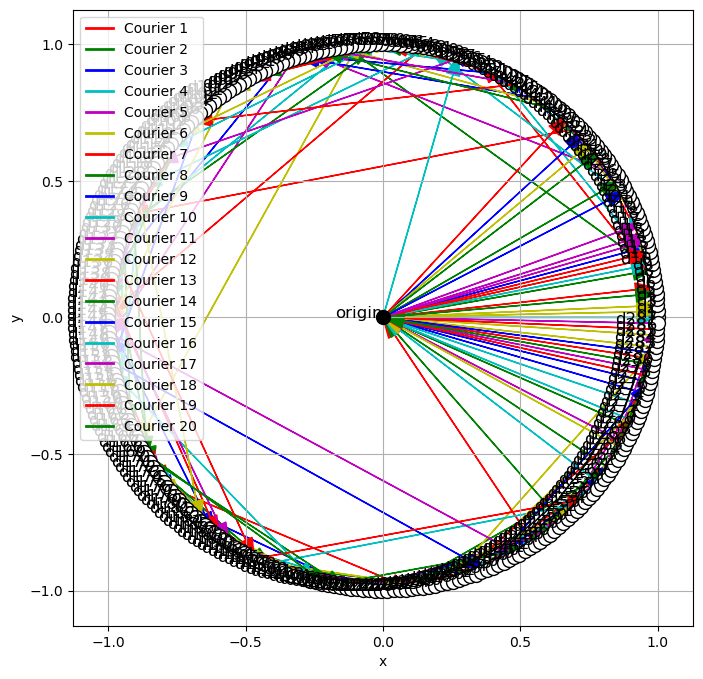

Instance: inst21.dat
Max Distance: 1012
Courier 1: Items [31, 49, 73, 86, 93, 94, 141]
Courier 1 Route: [144, 31, 49, 73, 86, 93, 94, 141, 144]
Courier 2: Items [6, 17, 55, 56, 65, 91, 106, 122, 138]
Courier 2 Route: [144, 6, 17, 55, 56, 65, 91, 106, 122, 138, 144]
Courier 3: Items [11, 28, 58, 62, 68, 71, 87, 105, 109, 118, 128, 133]
Courier 3 Route: [144, 11, 28, 58, 62, 68, 71, 87, 105, 109, 118, 128, 133, 144]
Courier 4: Items [4, 51, 53, 63, 67, 78, 95, 108, 139]
Courier 4 Route: [144, 4, 51, 53, 63, 67, 78, 95, 108, 139, 144]
Courier 5: Items [32, 47, 81, 82, 101, 125]
Courier 5 Route: [144, 32, 47, 81, 82, 101, 125, 144]
Courier 6: Items [5, 20, 64, 77, 80, 90, 102, 107]
Courier 6 Route: [144, 5, 20, 64, 77, 80, 90, 102, 107, 144]
Courier 7: Items [19, 27, 29, 70, 85, 92, 112]
Courier 7 Route: [144, 19, 27, 29, 70, 85, 92, 112, 144]
Courier 8: Items [23, 26, 50, 72, 117, 123, 126, 132]
Courier 8 Route: [144, 23, 26, 50, 72, 117, 123, 126, 132, 144]
Courier 9: Items [15, 18, 21, 

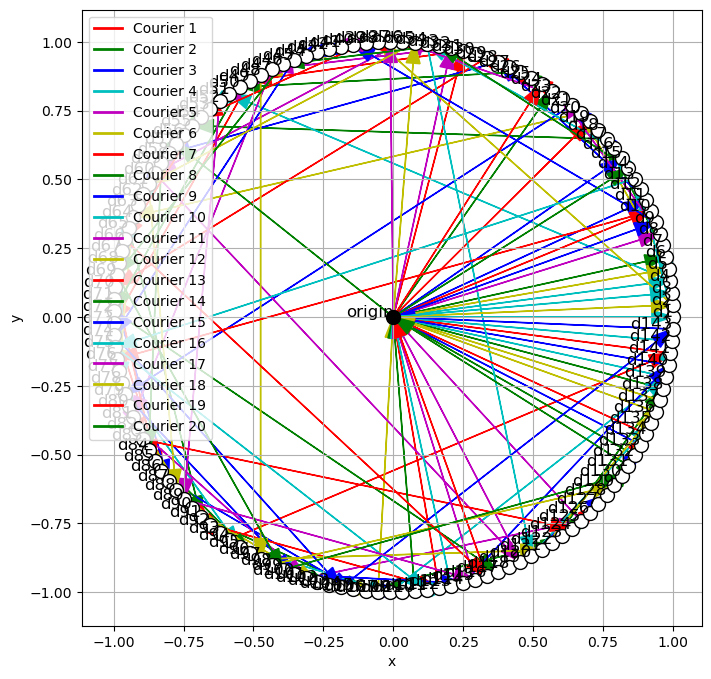

In [3]:
# Solve each instance and plot the results
for filename, instance in instances.items():
    result = solve_mcp(instance)
    if result:
        max_distance, solution, routes = result
        print(f"Instance: {filename}")
        print(f"Max Distance: {max_distance}")
        for i, items in enumerate(solution):
            assigned_items = [j+1 for j, assigned in enumerate(items) if is_true(assigned)]
            print(f"Courier {i+1}: Items {assigned_items}")
            print(f"Courier {i+1} Route: {[x + 1 for x in routes[i]]}")  # Adjust for 1-based indexing in output
        plot_routes(routes, instance)
    else:
        print(f"Instance: {filename} could not be solved within the time limit")